In [24]:
!pip install folium
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from sklearn.metrics import silhouette_score

print('Libraries imported.')

     |████████████████████████████████| 94 kB 4.1 MB/s  eta 0:00:01
Libraries imported.


In [25]:
import requests
from bs4 import BeautifulSoup

URL = "https://fr.wikipedia.org/wiki/Cat%C3%A9gorie:Arrondissement_de_Marrakech"
r = requests.get(URL)

soup = BeautifulSoup(r.content, 'html5lib') # If this line causes an error, run 'pip install html5lib' or install html5lib


neighborhoods=[]
div=soup.find("div", {"class":"mw-content-ltr"})
lis = div.findAll('li')[-5:]

for li in lis:
    neighborhood = li.text
    neighborhoods.append(neighborhood)


df=pd.DataFrame({"Neighborhood":neighborhoods})

df['Neighborhood'][0] = "Ennakhil, Marrakech"

df

,Neighborhood
0,"Ennakhil, Marrakech"
1,Guéliz
2,Marrakech-Médina
3,Ménara (arrondissement)
4,Sidi Youssef Ben Ali


In [26]:
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
geolocator = Nominatim(user_agent="Marrakech_food")

df['Coord']= df['Neighborhood'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
df[['Latitude', 'Longitude']] = df['Coord'].apply(pd.Series)

df.drop(['Coord'], axis=1, inplace=True)

marrakech_data = df
marrakech_data

,Neighborhood,Latitude,Longitude
0,"Ennakhil, Marrakech",31.648666,-7.963090
1,Guéliz,31.632188,-8.010813
2,Marrakech-Médina,31.625826,-7.989161
3,Ménara (arrondissement),31.628555,-8.057550
4,Sidi Youssef Ben Ali,31.609005,-7.967901


In [4]:
address = 'Marrakech'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Marrakech are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Marrakech are 31.626794750000002, -8.003024256894616.


In [27]:
map_marrakech = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(marrakech_data['Latitude'], marrakech_data['Longitude'], marrakech_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_marrakech)  
    
map_marrakech

In [28]:
CLIENT_ID = 'EQG4WGKSW2UTHTSNIL1IM0MMJTNY4RN3ESAF0VQO1XE5CNI4' # your Foursquare ID
CLIENT_SECRET = 'AJSRXBB10THVQCT1XW3NQPACQPPKFHER5ZNXFXGJ43U355GX' # your Foursquare Secret

VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EQG4WGKSW2UTHTSNIL1IM0MMJTNY4RN3ESAF0VQO1XE5CNI4
CLIENT_SECRET:AJSRXBB10THVQCT1XW3NQPACQPPKFHER5ZNXFXGJ43U355GX


In [29]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [30]:
marrakech_venues = getNearbyVenues(names=marrakech_data['Neighborhood'],
                                   latitudes=marrakech_data['Latitude'],
                                   longitudes=marrakech_data['Longitude']
                                  )
marrakech_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Ennakhil, Marrakech",31.648666,-7.963090,pharmacie borj ennakhil,31.648617,-7.963117,Pharmacy
1,"Ennakhil, Marrakech",31.648666,-7.963090,"Ryad Al Assala, Palmeraie",31.651886,-7.960317,Hotel Pool
2,Guéliz,31.632188,-8.010813,snack Al Bahriya,31.632500,-8.011736,Seafood Restaurant
3,Guéliz,31.632188,-8.010813,Grand Café de la Poste,31.633083,-8.009791,French Restaurant
4,Guéliz,31.632188,-8.010813,Azar,31.631774,-8.012992,Middle Eastern Restaurant
5,Guéliz,31.632188,-8.010813,L'Entrepotes,31.634356,-8.009958,French Restaurant
6,Guéliz,31.632188,-8.010813,Le Studio,31.632518,-8.010995,French Restaurant
7,Guéliz,31.632188,-8.010813,Bagatelle,31.632853,-8.013390,French Restaurant
8,Guéliz,31.632188,-8.010813,Radisson Blu,31.634876,-8.011475,Hotel
9,Guéliz,31.632188,-8.010813,Le Gueliz,31.633636,-8.010320,Café


In [31]:
marrakech_restaurant_venues = marrakech_venues[marrakech_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
marrakech_restaurant_venues.index = np.arange(1, len(marrakech_restaurant_venues )+1)

category_ranking = marrakech_restaurant_venues['Venue Category'].value_counts().to_frame(name='Frequency')

category_ranking

,Frequency
Moroccan Restaurant,13
French Restaurant,6
Italian Restaurant,3
Restaurant,3
Seafood Restaurant,2
Asian Restaurant,1
Spanish Restaurant,1
Middle Eastern Restaurant,1
African Restaurant,1
Thai Restaurant,1


In [32]:
print('There are {} distinct restaurant types in Marrakech.'.format(len(marrakech_restaurant_venues['Venue Category'].unique())))

There are 11 distinct restaurant types in Marrakech.


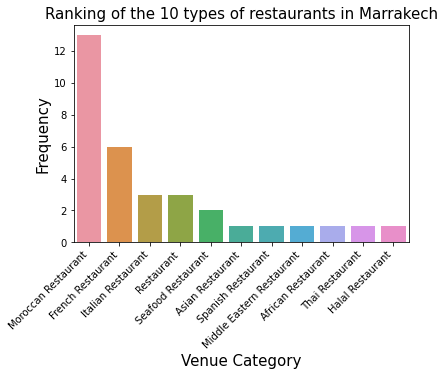

<Figure size 1296x504 with 0 Axes>

In [33]:
import seaborn as sns
from matplotlib import pyplot as plt

s=sns.barplot(x=category_ranking.index, y="Frequency", data=category_ranking)
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('Ranking of the 10 types of restaurants in Marrakech', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("restaurant_venues_ranking.png", dpi=300)
fig = plt.figure(figsize=(18,7))
plt.show()

In [34]:
marrakech_onehot = pd.get_dummies(marrakech_restaurant_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
marrakech_onehot['Neighborhood'] = marrakech_restaurant_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [marrakech_onehot.columns[-1]] + list(marrakech_onehot.columns[:-1])
marrakech_onehot = marrakech_onehot[fixed_columns]

marrakech_onehot.head()

,Neighborhood,African Restaurant,Asian Restaurant,French Restaurant,Halal Restaurant,Italian Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Restaurant,Seafood Restaurant,Spanish Restaurant,Thai Restaurant
1,Guéliz,0,0,0,0,0,0,0,0,1,0,0
2,Guéliz,0,0,1,0,0,0,0,0,0,0,0
3,Guéliz,0,0,0,0,0,1,0,0,0,0,0
4,Guéliz,0,0,1,0,0,0,0,0,0,0,0
5,Guéliz,0,0,1,0,0,0,0,0,0,0,0


In [35]:
marrakech_grouped = marrakech_onehot.groupby('Neighborhood').mean().reset_index()
marrakech_grouped

,Neighborhood,African Restaurant,Asian Restaurant,French Restaurant,Halal Restaurant,Italian Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Restaurant,Seafood Restaurant,Spanish Restaurant,Thai Restaurant
0,Guéliz,0.0000,0.0,0.428571,0.0,0.214286,0.071429,0.071429,0.000,0.142857,0.071429,0.0000
1,Marrakech-Médina,0.0625,0.0,0.000000,0.0,0.000000,0.000000,0.750000,0.125,0.000000,0.000000,0.0625
2,Ménara (arrondissement),0.0000,0.5,0.000000,0.5,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0000
3,Sidi Youssef Ben Ali,0.0000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.000,0.000000,0.000000,0.0000


In [36]:
num_top_venues = 3

for hood in marrakech_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = marrakech_grouped[marrakech_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Guéliz----
                venue  freq
0   French Restaurant  0.43
1  Italian Restaurant  0.21
2  Seafood Restaurant  0.14


----Marrakech-Médina----
                 venue  freq
0  Moroccan Restaurant  0.75
1           Restaurant  0.12
2   African Restaurant  0.06


----Ménara (arrondissement)----
                venue  freq
0    Asian Restaurant   0.5
1    Halal Restaurant   0.5
2  African Restaurant   0.0


----Sidi Youssef Ben Ali----
                venue  freq
0          Restaurant   1.0
1  African Restaurant   0.0
2    Asian Restaurant   0.0




In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [38]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = marrakech_grouped['Neighborhood']

for ind in np.arange(marrakech_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(marrakech_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Guéliz,French Restaurant,Italian Restaurant,Seafood Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Spanish Restaurant,African Restaurant,Asian Restaurant,Halal Restaurant,Restaurant
1,Marrakech-Médina,Moroccan Restaurant,Restaurant,African Restaurant,Thai Restaurant,Asian Restaurant,French Restaurant,Halal Restaurant,Italian Restaurant,Middle Eastern Restaurant,Seafood Restaurant
2,Ménara (arrondissement),Asian Restaurant,Halal Restaurant,African Restaurant,French Restaurant,Italian Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Restaurant,Seafood Restaurant,Spanish Restaurant
3,Sidi Youssef Ben Ali,Restaurant,African Restaurant,Asian Restaurant,French Restaurant,Halal Restaurant,Italian Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Seafood Restaurant,Spanish Restaurant


In [39]:
kclusters = 3

marrakech_grouped_clustering = marrakech_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(marrakech_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20]

array([0, 0, 1, 2], dtype=int32)

In [40]:
marrakech_merged = marrakech_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
marrakech_merged = marrakech_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

marrakech_merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Ennakhil, Marrakech",31.648666,-7.963090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Guéliz,31.632188,-8.010813,French Restaurant,Italian Restaurant,Seafood Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Spanish Restaurant,African Restaurant,Asian Restaurant,Halal Restaurant,Restaurant
2,Marrakech-Médina,31.625826,-7.989161,Moroccan Restaurant,Restaurant,African Restaurant,Thai Restaurant,Asian Restaurant,French Restaurant,Halal Restaurant,Italian Restaurant,Middle Eastern Restaurant,Seafood Restaurant
3,Ménara (arrondissement),31.628555,-8.057550,Asian Restaurant,Halal Restaurant,African Restaurant,French Restaurant,Italian Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Restaurant,Seafood Restaurant,Spanish Restaurant
4,Sidi Youssef Ben Ali,31.609005,-7.967901,Restaurant,African Restaurant,Asian Restaurant,French Restaurant,Halal Restaurant,Italian Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Seafood Restaurant,Spanish Restaurant


In [42]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
# colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
# rainbow = [colors.rgb2hex(i) for i in colors_array]

colors = ['blue', 'purple', 'purple', 'green', '#ff0000']

# add markers to the map
markers_colors = []
i=0
for lat, lon, poi, cluster in zip(marrakech_merged['Latitude'], marrakech_merged['Longitude'], marrakech_merged['Neighborhood'], marrakech_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=colors[i],
        fill=True,
        fill_color=colors[i],
        fill_opacity=0.7).add_to(map_clusters)

    print(i)
    i=i+1
       
map_clusters

KeyError: 'Cluster Labels'

In [43]:
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

rainbow

AttributeError: 'list' object has no attribute 'rgb2hex'

In [21]:
marrakech_merged.loc[marrakech_merged['Cluster Labels'] == 0, marrakech_merged.columns[[0] + list(range(4, marrakech_merged.shape[1]))]]

KeyError: 'Cluster Labels'

In [22]:
marrakech_merged.loc[marrakech_merged['Cluster Labels'] == 1, marrakech_merged.columns[[0] + list(range(4, marrakech_merged.shape[1]))]]

KeyError: 'Cluster Labels'

In [23]:
marrakech_merged.loc[marrakech_merged['Cluster Labels'] == 2, marrakech_merged.columns[[0] + list(range(4, marrakech_merged.shape[1]))]]

KeyError: 'Cluster Labels'